# E/I balanced network

## Overviews

Van Vreeswijk and Sompolinsky proposed E-I balanced network in 1996 to explain the temporally irregular spiking patterns. They suggested that the temporal variability may originated from the balance between excitatory and inhibitory inputs.

There are $N_E$ excitatory neurons and $N_I$ inbibitory neurons.

An important feature of the network is random and sparse connectivity. Connections between neurons $K$ meets $1 << K << N_E$. 

## Implementations

In [1]:
import brainpy as bp
import numpy as np

bp.profile.set(backend='numba',
               device='cpu',
               merge_steps=True,
               numerical_method='exponential')

Dynamic of membrane potential is given as:

$$ \tau \frac {dV_i}{dt} = -(V_i - V_{rest}) + I_i^{ext} + I_i^{net} (t) $$

where $I_i^{net}(t)$ represents the synaptic current, which describes the sum of excitatory and inhibitory neurons.

$$ I_i^{net} (t) = J_E \sum_{j=1}^{pN_e} \sum_{t_j^\alpha < t} f(t-t_j^\alpha ) - J_I \sum_{j=1}^{pN_i} \sum_{t_j^\alpha < t} f(t-t_j^\alpha )$$

where 

$$ f(t) = \begin{cases} {\rm exp} (-\frac t {\tau_s} ), \quad t \geq 0 \\
0, \quad t < 0 \end{cases} $$

Parameters: $J_E = \frac 1 {\sqrt {pN_e}}, J_I = \frac 1 {\sqrt {pN_i}}$

We can see from the dynamic that network is based on leaky Integrate-and-Fire neurons, and we can just use `get_LIF` from `bpmodels.neurons` to get this model. 

In [2]:
from bpmodels.neurons import get_LIF
V_rest = -52.
V_reset = -60.
V_th = -50.

neu = get_LIF(V_rest=V_rest, V_reset = V_reset, V_th=V_th, noise=0.)

The function of $I_i^{net}(t)$ is actually a synase with single exponential decay, we can also get it by using `get_exponential`.

In [3]:
from bpmodels.synapses import get_exponential
syn = get_exponential(tau_decay = 2.)

### Network

Let's create a neuron group with $N_E$ excitatory neurons and $N_I$ inbibitory neurons. We can appoint different synapse connection to the two kinds of neurons by using `group[:num_exc]` to get group slices. 

Use `conn=bp.connect.FixedProb(p)` to implement the random and sparse connections.

In [5]:
num_exc = 500
num_inh = 500
prob = 0.15

JE = 1 / np.sqrt(prob * num_exc)
JI = 1 / np.sqrt(prob * num_inh)

group = bp.NeuGroup(neu,
                    geometry=num_exc + num_inh,
                    monitors=['spike'])
group.ST['V'] = np.random.random(num_exc + num_inh) * (V_th - V_rest) + V_rest

exc_conn = bp.SynConn(syn,
                      pre_group=group[:num_exc],
                      post_group=group,
                      conn=bp.connect.FixedProb(prob=prob))
exc_conn.pars['g_max'] = JE

inh_conn = bp.SynConn(syn,
                      pre_group=group[num_exc:],
                      post_group=group,
                      conn=bp.connect.FixedProb(prob=prob))
inh_conn.pars['g_max'] = -JI

net = bp.Network(group, exc_conn, inh_conn)
net.run(duration=1000., inputs=[(group, 'ST.input', 3.)], report=True)

Compilation used 3.4734 s.
Start running ...
Run 10.0% used 2.926 s.
Run 20.0% used 5.714 s.
Run 30.0% used 8.742 s.
Run 40.0% used 14.678 s.
Run 50.0% used 19.061 s.
Run 60.0% used 22.934 s.
Run 70.0% used 26.106 s.
Run 80.0% used 29.940 s.
Run 90.0% used 33.559 s.
Run 100.0% used 36.788 s.
Simulation is done in 36.788 s.


### Visualization

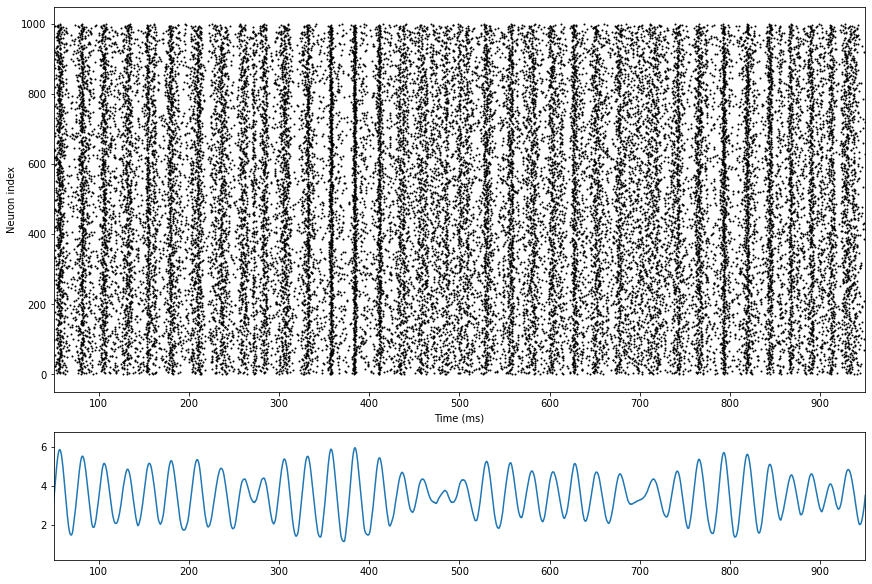

In [6]:
import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(4, 1, 2, 12)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(net.ts, group.mon.spike, xlim=(50, 950))

fig.add_subplot(gs[3, 0])
rates = bp.measure.firing_rate(group.mon.spike, 5.)
plt.plot(net.ts, rates)
plt.xlim(50, 950)
plt.show()